## Obligatorio

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from collections import Counter

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import wandb
from wandb.keras import WandbCallback

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lucianamaschi (lu-ger). Use `wandb login --relogin` to force relogin


True

In [3]:
import random
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
connection_string = "DefaultEndpointsProtocol=https;AccountName=lucianagerman4638471639;AccountKey=s3ctA9+X+SqyzvUbgzESug9elvK5YbHEKD7Px4RuFu5SG/34BuO5zl+AkbffpYG1q8J+LSbjnpqp+AStfiXepA==;EndpointSuffix=core.windows.net"
container_name = "azureml-blobstore-712d0730-8ebc-42ee-99e3-a783cdcdbbff"

blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

In [5]:
# Obtener la lista de blobs en el contenedor
blob_list = container_client.list_blobs()

def load_image(blob):

    blob_client = blob_service_client.get_blob_client(container_name, blob.name)
    blob_data = blob_client.download_blob().readall()
    image = tf.image.decode_image(blob_data)
    #image.shape: TensorShape([768, 1024, 3])
    image = tf.image.resize(image, (120, 160)) 
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    label = blob.name.split("_")[1].split(".")[0]
    return image, label

images = []

for blob in [blob for blob in blob_list if blob.name.startswith('images')]:
        image, label = load_image(blob)
        images.append((image, label))
    
images = np.array(images)


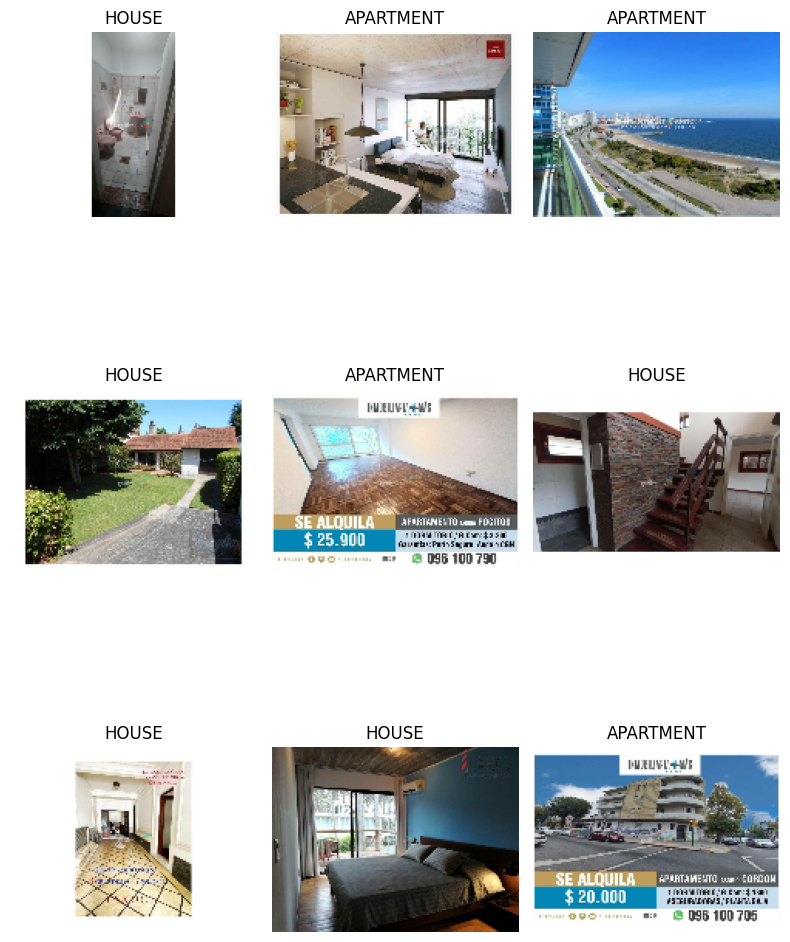

In [6]:
# Función para visualizar imágenes de muestra y sus etiquetas
def plot_sample_images(x, y):
    plt.figure(figsize=(8, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.clip(x[i], 0, 1))
        plt.title(y[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar imágenes de muestra y sus etiquetas
np.random.shuffle(images)
plot_sample_images([tupla[0] for tupla in images], [tupla[1] for tupla in images])

In [7]:
images = [tupla for tupla in images if tupla[1] != 'error']

In [8]:
# Dividir el objeto Dataset en conjuntos de entrenamiento y prueba
images_train, images_test = train_test_split(images, test_size=0.2, random_state=42)

x_train=np.array([image[0] for image in images_train])
y_train=np.array([label[1] for label in images_train])

x_test=np.array([image[0] for image in images_test])
y_test=np.array([label[1] for label in images_test])

binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train)
y_test = binarizer.fit_transform(y_test)

# Convertir las etiquetas en one-hot
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)


In [9]:
# Accede a las etiquetas originales
class_labels = binarizer.classes_
class_labels

array(['APARTMENT', 'HOUSE'], dtype='<U9')

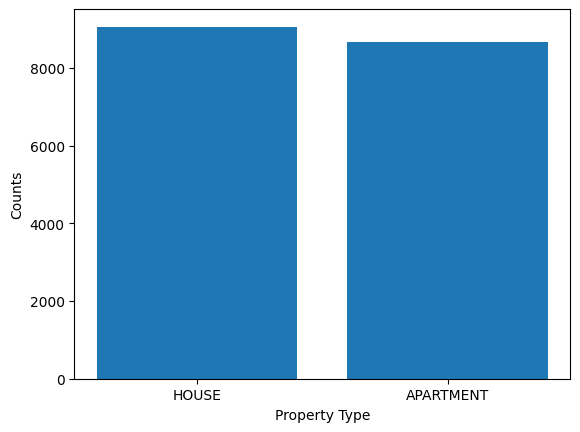

In [10]:
labels, counts= zip(*Counter([label[1] for label in images_train]).items())
plt.bar(labels, counts)
# Add labels and title
plt.xlabel('Property Type')
plt.ylabel('Counts')

# Show the plot
plt.show()

In [ ]:
model_name='model_final'

# Start a run, tracking hyperparameters
wandb.init(
    project="ml-in-prod",
    config={

        "activation_1": "relu",
        "activation_out": "sigmoid",
        "dropout1": 0.3,
        "dropout2": 0.5,
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 100,
        "batch_size": 128,
        "learning_rate":0.001
    },
)
config = wandb.config

# Define tu modelo
resize = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(32, 32)
])
model = tf.keras.models.Sequential([
    resize,
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=config.activation_1, input_shape=(32,32,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=config.activation_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(config.dropout1),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=config.activation_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=config.activation_1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(config.dropout2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(config.dropout2),
    tf.keras.layers.Dense(2, activation=config.activation_out)
])

# Add WandbMetricsLogger to log metrics and WandbModelCheckpoint to log model checkpoints
wandb_callbacks = [
        WandbMetricsLogger(),
        ModelCheckpoint(filepath=model_name+"_{epoch:02d}", save_best_only=True),
    ]

# Compila y entrena el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate), loss=config.loss, metrics=[config.metric])
history = model.fit(x_train, y_train, batch_size=config.batch_size, epochs=config.epoch, validation_data=(x_test, y_test), callbacks=wandb_callbacks)

wandb.finish()


In [ ]:
# model_name='h_tuning'

# sweep_config = {
#     'method': 'grid',  # el método de búsqueda de hiperparámetros
#     'metric': {
#       'name': 'accuracy',
#       'goal': 'maximize'  
#     },
#     'parameters': {
#         "metric":{
#             'values': ["accuracy"]
#         },
#         "activation_1":{
#             'values': ["relu"]
#         },
#         "activation_out": {
#             'values': ["sigmoid"]
#         },
#         "optimizer": {
#             'values': ["adam"]
#         },
#         "loss": {
#             'values': ["binary_crossentropy"]
#         },
#         "epoch": {
#             'values': [100]
#         },
#         "dropout1": {
#             'values': [0.2, 0.3 ,0.4]
#         },
#         "dropout2": {
#             'values': [0.3,0.4,0.5]
#         },
#         'learning_rate': {
#             'values': [0.1, 0.01, 0.001, 0.0001]
#         },
#         'batch_size': {
#             'values': [64, 128, 256]
#         },
#     }
# }

# sweep_id = wandb.sweep(sweep_config, project="ml-in-prod")

# # Define tu modelo
# resize = tf.keras.models.Sequential([
#     tf.keras.layers.experimental.preprocessing.Resizing(32, 32)
# ])
# model = tf.keras.models.Sequential([
#     resize,
#     tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=config.activation_1, input_shape=(32,32,3)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=config.activation_1),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Dropout(config.dropout1),

#     tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=config.activation_1),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=config.activation_1),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Dropout(config.dropout2),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(config.dropout2),
#     tf.keras.layers.Dense(2, activation=config.activation_out)
# ])

# # Add WandbMetricsLogger to log metrics and WandbModelCheckpoint to log model checkpoints


# def train():
#     run = wandb.init()
#     config = run.config
#     wandb_callbacks = [
#         WandbMetricsLogger(),
#         ModelCheckpoint(filepath=model_name+"_{epoch:02d}", save_best_only=True),
#     ]
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate), loss=config.loss, metrics=[config.metric])
#     history = model.fit(x_train, y_train, batch_size=config.batch_size, epochs=config.epoch, validation_data=(x_test, y_test), callbacks=[wandb_callbacks])

# wandb.agent(sweep_id, function=train)



In [18]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    multiple                  0         
_________________________________________________________________
conv2d_16 (Conv2D)           multiple                  896       
_________________________________________________________________
batch_normalization_20 (Batc multiple                  128       
_________________________________________________________________
conv2d_17 (Conv2D)           multiple                  9248      
_________________________________________________________________
batch_normalization_21 (Batc multiple                  128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_12 (Dropout)         multiple                 

In [ ]:
def plot_history(history):
    history_df = pd.DataFrame(history.history)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Training')
    plt.plot(history_df['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Training')
    plt.plot(history_df['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('training_validation_plots.png')
    plt.show()

# Call the plotting function to display the graphs
plot_history(history)

# Save the trained model
model.save('conv.h5')